## Pneumonia Detection on Chest X-Rays with Deep Learning

The dataset comes from this [paper](https://arxiv.org/pdf/1711.05225.pdf)

Also, implementing this [paper] (https://arxiv.org/pdf/1610.02391.pdf)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn import metrics
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from datetime import datetime
import cv2
from collections import OrderedDict

In [2]:
import os
from tqdm import tqdm_notebook as tqdm

In [3]:
PATH = Path("/data2/yinterian/ChestXray/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/ChestXray/images'),
 PosixPath('/data2/yinterian/ChestXray/val_df.csv'),
 PosixPath('/data2/yinterian/ChestXray/images_250'),
 PosixPath('/data2/yinterian/ChestXray/test_df.csv'),
 PosixPath('/data2/yinterian/ChestXray/images_010.zip'),
 PosixPath('/data2/yinterian/ChestXray/images_001.zip'),
 PosixPath('/data2/yinterian/ChestXray/README_CHESTXRAY.pdf'),
 PosixPath('/data2/yinterian/ChestXray/test_list.txt'),
 PosixPath('/data2/yinterian/ChestXray/ARXIV_V5_CHESTXRAY.pdf'),
 PosixPath('/data2/yinterian/ChestXray/images_011.zip'),
 PosixPath('/data2/yinterian/ChestXray/images_004.zip'),
 PosixPath('/data2/yinterian/ChestXray/BBox_List_2017.csv'),
 PosixPath('/data2/yinterian/ChestXray/images_007.zip'),
 PosixPath('/data2/yinterian/ChestXray/Data_Entry_2017.csv'),
 PosixPath('/data2/yinterian/ChestXray/images_002.zip'),
 PosixPath('/data2/yinterian/ChestXray/images_008.zip'),
 PosixPath('/data2/yinterian/ChestXray/val_Pneumonia_df.csv'),
 PosixPath('/data2/yin

## Preprocessing 

In [4]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [5]:
images_paths = list((PATH/"images").iterdir())

In [6]:
images_paths[:10]

[PosixPath('/data2/yinterian/ChestXray/images/00021341_016.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00011460_012.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00005311_000.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00021120_000.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00029431_003.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00027564_002.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00006271_096.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00004461_014.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00020917_000.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00012402_000.png')]

## Random transforms

In [7]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    r_pix = 8
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x):
    r, c,*_ = x.shape
    r_pix = 8
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

## Dataset

In [8]:
def norm_for_imageNet(img):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (img - imagenet_stats[0])/imagenet_stats[1]

In [9]:
def apply_transforms(x):
    """ Applies a random crop, rotation"""
    rdeg = (np.random.random()-.50)*20
    x = rotate_cv(x, rdeg)
    if np.random.random() > 0.5: x = np.fliplr(x).copy() 
    x = random_crop(x)
    return x

class ChestXrayDataSet(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            dataframe with data: image_file, label
            transform: if True apply transforms to images
        """
        self.image_files = df["ImageIndex"].values
        self.labels = df["Label"].values
        self.transform = transform
        self.image_path = PATH/"images_250"

    def __getitem__(self, index):
        path = self.image_path/self.image_files[index]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transform:
            x = apply_transforms(x)
        else:
            x = center_crop(x)
            
        x = norm_for_imageNet(x)
        y = np.array([int(i) for i in self.labels[index].split(" ")]).astype(np.float32)
        return np.rollaxis(x, 2), y

    def __len__(self):
        return len(self.image_files)

In [10]:
class ChestXrayDataSetUnsupervised(Dataset):
    def __init__(self, df, N):
        """
        Args:
            dataframe with data: image_file, label
            transform: if True apply transforms to images
        """
        paths = np.array([PATH/"images_250"/x for x in df["ImageIndex"].values])
        replace = False
        if N > len(paths): replace = True
        self.paths = np.random.choice(paths, size=N, replace=replace)
        self.len = N 

    def __getitem__(self, index):
        path = self.paths[index]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        x_trans = apply_transforms(x.copy())
        x_reg = center_crop(x)
            
        x_trans = norm_for_imageNet(x_trans)
        x_reg = norm_for_imageNet(x_reg)  
        return np.rollaxis(x_reg, 2), np.rollaxis(x_trans, 2)

    def __len__(self):
        return self.len

In [11]:
train_df = pd.read_csv(PATH/"train_df.csv")
val_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

In [12]:
val_df.shape, train_df.shape, test_df.shape

((9069, 2), (77455, 2), (25596, 2))

In [13]:
batch_size = 10
train_ds = ChestXrayDataSet(train_df, transform=True)
valid_ds = ChestXrayDataSet(val_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=1)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=1)

In [14]:
unsuper_ds = ChestXrayDataSetUnsupervised(test_df, N=len(train_ds))
unsuper_dl = DataLoader(unsuper_ds, batch_size=batch_size, shuffle=True)

In [15]:
x, x_t = unsuper_ds[0]

In [16]:
x.shape, x_t.shape

((3, 234, 234), (3, 234, 234))

## Model 

In [17]:
class DenseNet(nn.Module):
    def __init__(self, out_size=14):
        super(DenseNet, self).__init__()
        self.densenet121 = models.densenet121(pretrained=True)
        layers = list(self.densenet121.children())[0]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:7], layers[7:]]])
        self.groups.append(nn.Linear(1024, out_size))

    def forward(self, x):
        for group in self.groups[:-1]:
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[-1](x)
        return x

In [25]:
model = DenseNet()

In [26]:
x,y = next(iter(train_dl))
x = x.float()
y = y.float()

In [27]:
pred = model(x)
F.binary_cross_entropy_with_logits(pred, y).item()

0.6999444961547852

In [28]:
x, x_t = next(iter(unsuper_dl))

In [30]:
def kl_divergence_with_logits(logit, logit_t):
  p = F.softmax(logit, dim=1)
  log_p = F.log_softmax(logit, dim=1)
  log_q = F.log_softmax(logit_t, dim=1)
  kl = (p * (log_p - log_q)).sum(1).mean()
  return kl

## Metrics

In [31]:
def ave_auc(probs, ys):
    probs = np.vstack(probs)
    ys = np.vstack(ys)
    aucs = [metrics.roc_auc_score(ys[:,i], probs[:,i]) for i in range(probs.shape[1])]
    return np.mean(aucs), aucs

In [32]:
def val_metric(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    probs = []
    ys = []
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().long()
        out = model(x)
        probs.append(out.detach().cpu().numpy())
        ys.append(y.cpu().numpy())
        loss = F.binary_cross_entropy_with_logits(out, y.float())
        sum_loss += batch*(loss.item())
        total += batch
    mean_auc, _ = ave_auc(probs, ys)
    return sum_loss/total, mean_auc

In [ ]:
#val_metric(model, valid_dl)

## Training functions

In [34]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

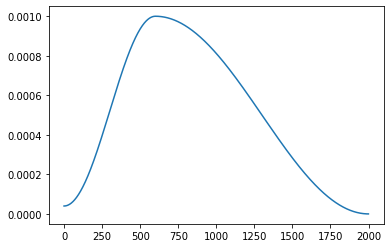

In [35]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [36]:
def diff_lr(lr, alpha=1/3):
    return [lr*alpha**i for i in range(2,-1,-1)]

def create_optimizer(model, lr_0):
    param_groups = [list(model.groups[i].parameters()) for i in range(3)]
    params = [{'params':p, 'lr': lr} for p,lr in zip(param_groups, diff_lr(lr_0))]
    return optim.Adam(params)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [37]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    pbar = tqdm(total=iterations)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_auc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for (x,y), (x1,x2) in zip(train_dl, unsuper_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            
            # second loss
            x = x1.cuda().float()
            with torch.no_grad():
                logit1 = model(x)
            x2 = x2.cuda().float()
            logit2 = model(x2)
            loss += kl_divergence_with_logits(logit1, logit2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            pbar.update()
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_auc = val_metric(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_auc %.3f \n" % 
              (train_loss, val_loss, val_auc))
        if val_auc > prev_val_auc:
            prev_val_auc = val_auc
            path = "{0}/models/model_densenet_auc_{1:.0f}.pth".format(PATH, 100*val_auc) 
            save_model(model, path)
            print(path)
    return sum_loss/total

In [38]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    pbar = tqdm(total=iterations)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    optimizer = create_optimizer(model, lrs[0])
    model.train()
    ind = 0
    prev_loss = 0
    for i in range(epochs):
        for x,y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append((prev_loss + loss.item())/2)
            prev_loss = loss.item()
            ind +=1
            pbar.update()
            
    load_model(model, str(p))
    return lrs[1:], losses[1:]

In [39]:
#model = DenseNet().cuda()
#lrs, losses = LR_range_finder(model, train_dl, lr_high=0.01)

In [40]:
#plt.plot(lrs, losses)
#plt.show()

## Run Training

In [ ]:
model = DenseNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.002, epochs = 10)